# Preprocessing Concepts

### Below is a sample where we just print the center, left, right camera views, all data pre-processing will be made to work in this file before we architect/train the network

In [1]:
import csv, cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import time, random
from math import isclose

STEER_CORRECTION = .25

start = time.time()

data = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        data.append(line)

data = shuffle(data)

def load_train_data(using_custom):
    fp1 = './data/driving_log.csv'
    fp2 = './recovery_data/driving_log.csv'

    data = []
    
    fileToUpload = fp2 if using_custom else fp1
    with open(fileToUpload) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            data.append(line)

    image_paths = []
    steering_angles = []

    for img_file_label in data:    
           
        if using_custom:
            center = img_file_label[0].split('/')[-1]
            left = img_file_label[1].split('/')[-1]
            right = img_file_label[2].split('/')[-1]
        else:
            center = './data/IMG/'+ img_file_label[0].split('/')[-1]
            left = './data/IMG/'+ img_file_label[1].split('/')[-1]
            right = './data/IMG/'+ img_file_label[2].split('/')[-1]

        '''
        print(center)
        print(left)
        print(right)
        pause = input()
        '''
        
        if center == "./data/IMG/center":
            continue

        center_angle = float(img_file_label[3])
        left_angle = float(img_file_label[3]) + STEER_CORRECTION
        right_angle = float(img_file_label[3]) - STEER_CORRECTION
        
        coinFlip = random.random()
        if isclose(center_angle, 0.0):
            PROBABILITY_SKIP_ZERO_STEERING_ANGLE = .7 if using_custom else .7
            
            if coinFlip > PROBABILITY_SKIP_ZERO_STEERING_ANGLE:
                image_paths.extend( (center,left, right ) )
                steering_angles.extend( (center_angle, left_angle, right_angle) )
        else:
            image_paths.extend( (center,left, right ) )
            steering_angles.extend( (center_angle, left_angle, right_angle) )
        
    image_paths = np.array(image_paths)
    steering_angles = np.array(steering_angles)

    return image_paths, steering_angles

    
images, steering_angles = load_train_data(data)

finish = time.time()
print("It took: {} to upload, shuffle, put images to arrays".format(finish-start))

def display_two(a,b,ta,tb):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
    f.tight_layout()
    ax1.imshow(a)
    ax1.set_title(ta, fontsize=30)
    ax2.imshow(b)
    ax2.set_title(tb, fontsize=30)

It took: 0.2491755485534668 to upload, shuffle, put images to arrays


## Flipped images

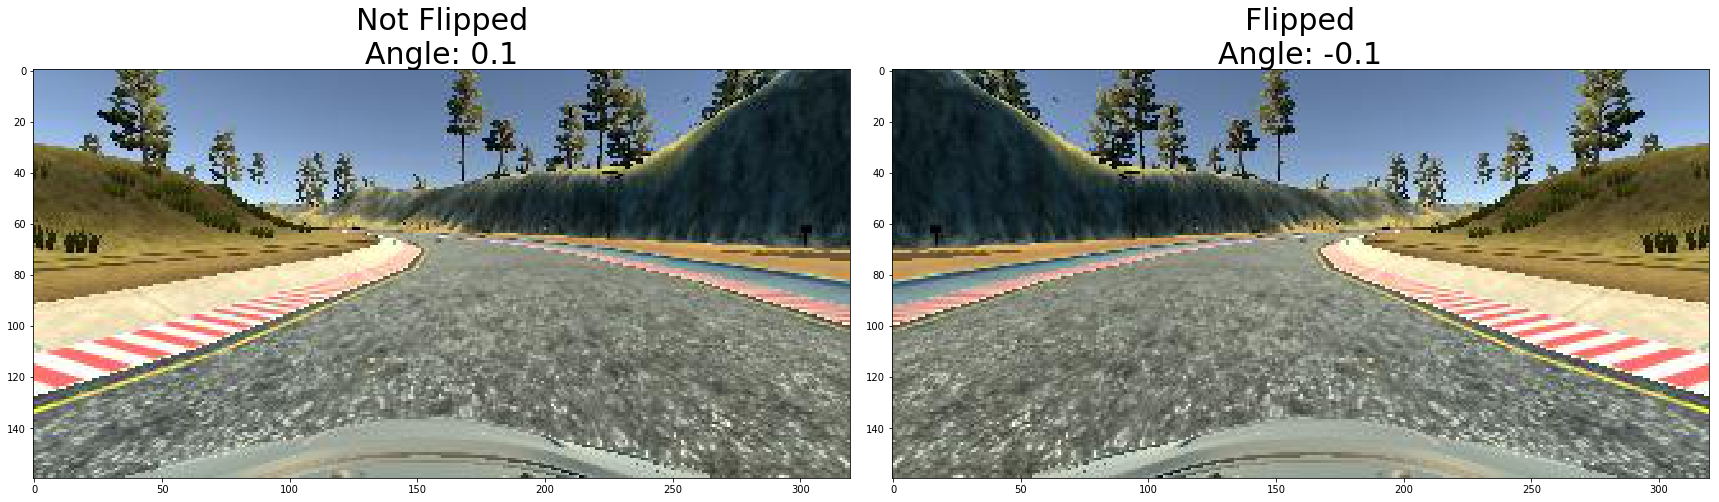

In [2]:
def flipImages(images, steering_angle):
    flipped = np.copy(np.fliplr(images))   
    return (flipped, -1 * steering_angle)

image_not_flipped = cv2.cvtColor(cv2.imread(images[0]) , cv2.COLOR_BGR2RGB)

not_flipped, angle_0 = image_not_flipped, steering_angles[0]
flipped_0, f_angle_0 = flipImages(not_flipped, angle_0) 


display_two(not_flipped,flipped_0,"Not Flipped\nAngle: {}".format(angle_0),"Flipped\nAngle: {}".format(f_angle_0))
plt.savefig("./examples/flipped-notflipped.png")

## Change brightness

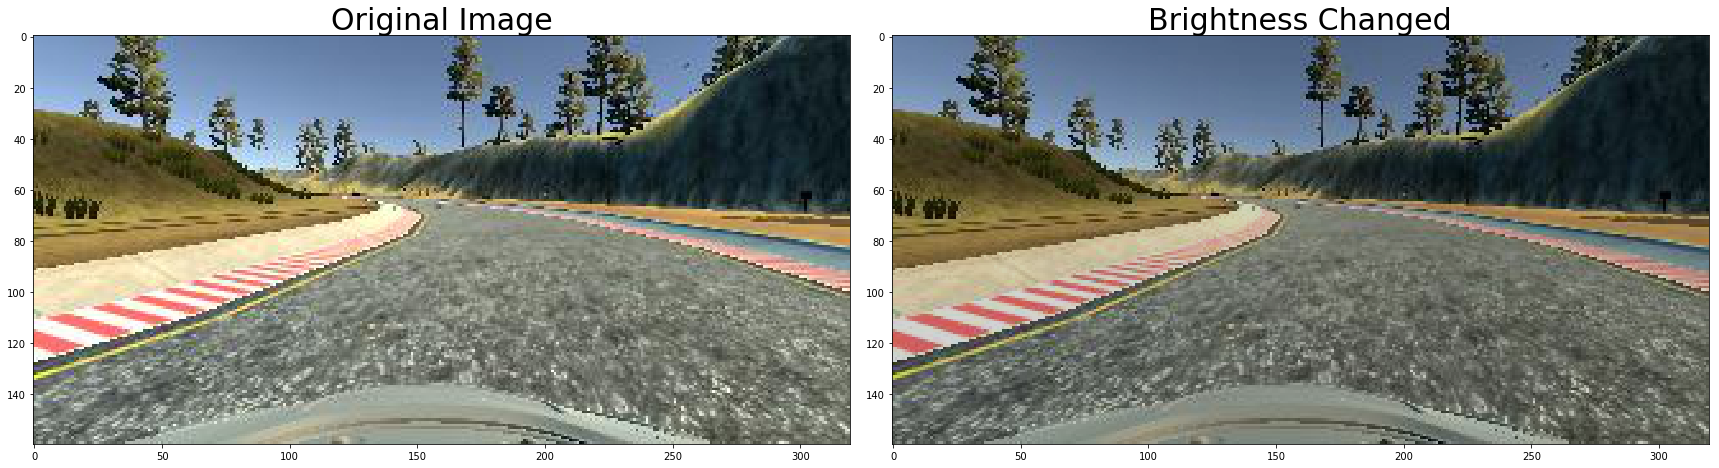

In [3]:
def change_brightness(image):
    img = np.copy(image)
    image1 = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1,dtype=np.float64)
    # uniform means all outcomes equally likely, 
    # defaults to [0,1)
    random_bright =  np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    # Data conversion and array slicing schemes -> Reference: the amazing Vivek Yadav
    # https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9
    #(np slicing) --> Put any pixel that was made greater than 255 back to 255
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

original_image = cv2.cvtColor(cv2.imread(images[0]), cv2.COLOR_BGR2RGB)
brightness_changed = change_brightness(original_image)    
plt.figure(figsize=(20, 25))
display_two(original_image,brightness_changed,"Original Image","Brightness Changed")
plt.savefig("./examples/brightness-original.png")
#plt.save("./examples/brightness-original.png")

## Crop
(found that if we take 50px off the top and 80 off the bottom the image is  totally road)

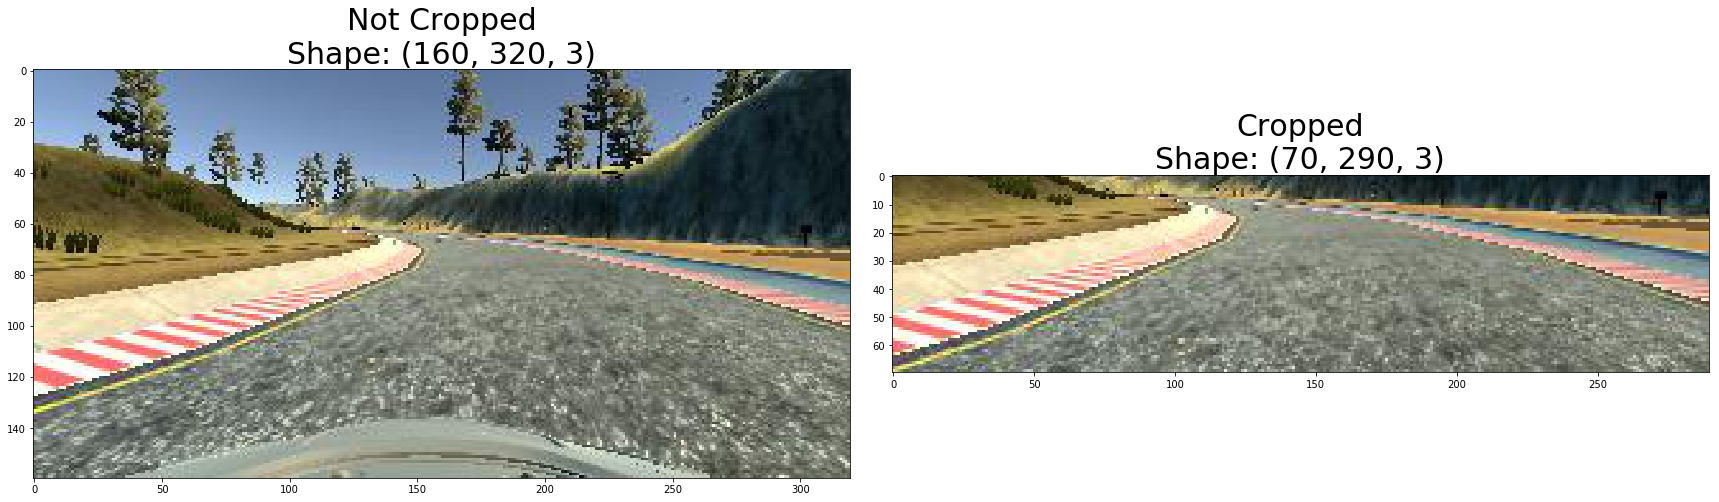

In [4]:

def cropImage(img):    
    
    # top to cut off, bottom to cut off
    x,w = 30,img.shape[1]-30
    
    #left to cut off, right to cut off
    y,h = 55, (img.shape[0] - 90)
    crop_img = np.copy(img[y:y+h, x:x+w])
    return crop_img

img = cv2.cvtColor(cv2.imread(images[0]) , cv2.COLOR_BGR2RGB)
crop_img = cropImage(img)



display_two(img,crop_img,"Not Cropped\nShape: {}".format(str(img.shape)), "Cropped\nShape: {}".format(str(crop_img.shape)))
plt.savefig("./examples/cropped-notcropped.png")

## Normalize
won't print because all RGB values would be -1,0 or 1 and we'd need a ceil function, etc.

In [5]:
def normalize(img):
    # given in a tutorial or something
    return img/255 - .5
an_image = images[0]
#an_image = normalize(an_image)

#print(images[0])
#print(an_image)

## Resize
to 200 x 166 per the NVIDIA model or 64 x 64 (since a simulator is a less complex environment than the real world) we found the best results with the 64x64

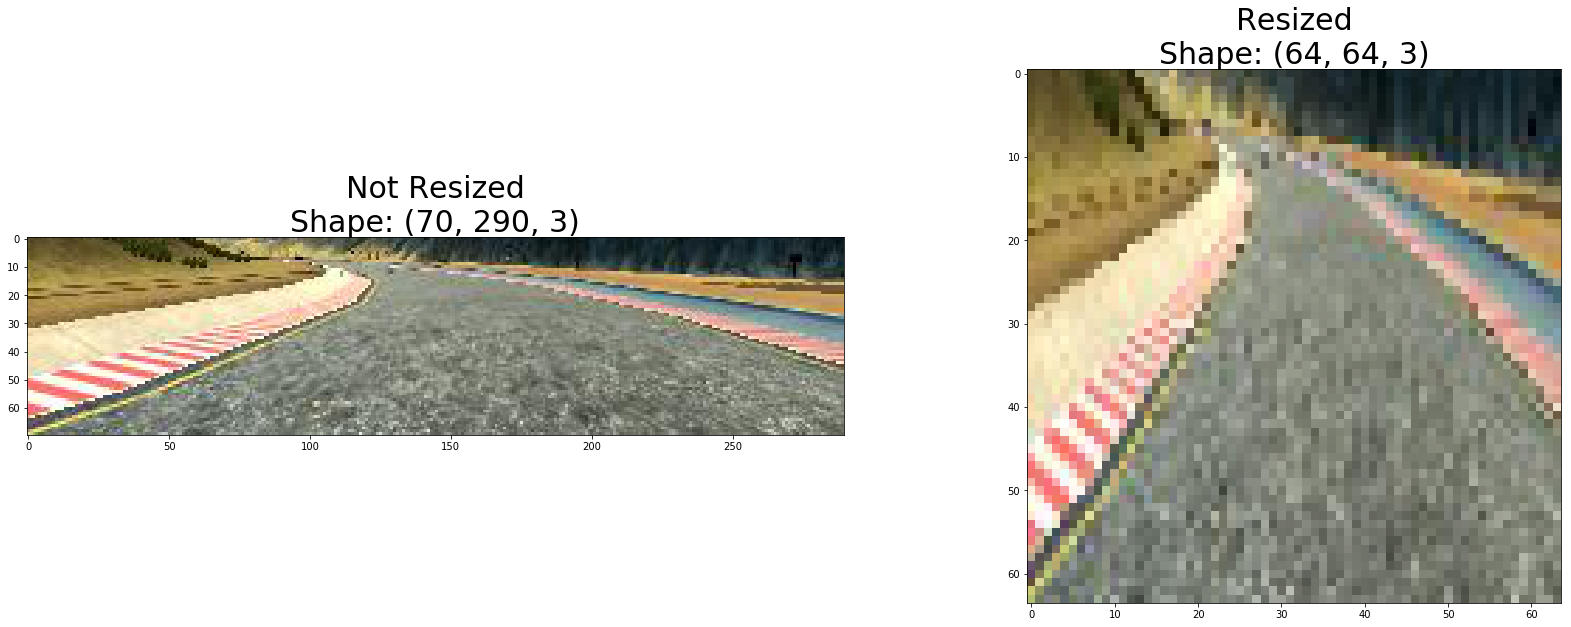

In [6]:
def resize(image):
    return np.copy(cv2.resize(image, (64,64) ) )
display_two(crop_img,resize(crop_img),"Not Resized\nShape: {}".format(str(crop_img.shape)), "Resized\nShape: {}".format(str(resize(crop_img).shape)))


## Flatten Steering Angle Distribution
(we want to get a before and after)

<class 'numpy.ndarray'>


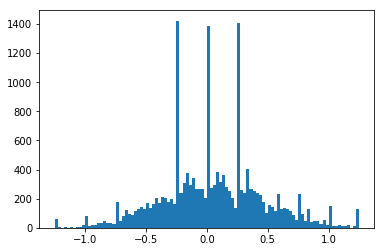

In [7]:
plt.hist(steering_angles,bins=100)

print(type(steering_angles))

In [8]:
from collections import Counter

angles = Counter(steering_angles)
print([i for i in list(angles.items()) if i[1] > 1000 ])

[(-0.25, 1197), (0.0, 1194), (0.25, 1226)]


In [9]:
def load_train_data2(using_custom):
    fp1 = './data/driving_log.csv'
    fp2 = './recovery_data/driving_log.csv'

    data = []
    
    fileToUpload = fp2 if using_custom else fp1
    with open(fileToUpload) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            data.append(line)

    image_paths = []
    steering_angles = []

    for img_file_label in data:    
           
        if using_custom:
            center = img_file_label[0].split('/')[-1]
            left = img_file_label[1].split('/')[-1]
            right = img_file_label[2].split('/')[-1]
        else:
            center = './data/IMG/'+ img_file_label[0].split('/')[-1]
            left = './data/IMG/'+ img_file_label[1].split('/')[-1]
            right = './data/IMG/'+ img_file_label[2].split('/')[-1]

        '''
        print(center)
        print(left)
        print(right)
        pause = input()
        '''
        
        if center == "./data/IMG/center":
            continue

        center_angle = float(img_file_label[3])
        left_angle = float(img_file_label[3]) + STEER_CORRECTION
        right_angle = float(img_file_label[3]) - STEER_CORRECTION
        
        coinFlip = random.random()
        if isclose(center_angle, 0.0):
            PROBABILITY_SKIP_ZERO_STEERING_ANGLE = -1
            
            if coinFlip > PROBABILITY_SKIP_ZERO_STEERING_ANGLE:
                image_paths.extend( (center,left, right ) )
                steering_angles.extend( (center_angle, left_angle, right_angle) )
        else:
            image_paths.extend( (center,left, right ) )
            steering_angles.extend( (center_angle, left_angle, right_angle) )
        
    image_paths = np.array(image_paths)
    steering_angles = np.array(steering_angles)

    return image_paths, steering_angles

    
images2, steering_angles2 = load_train_data2(data)

finish = time.time()
print("It took: {} to upload, shuffle, put images to arrays".format(finish-start))



It took: 5.523902416229248 to upload, shuffle, put images to arrays


<class 'numpy.ndarray'>
[(0.0, 4035), (0.25, 4067), (-0.25, 4038)]


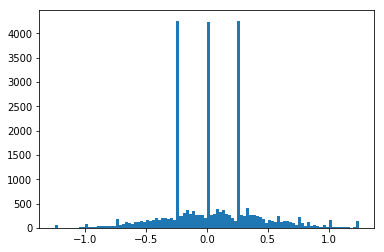

In [10]:
plt.hist(steering_angles2, bins=100)
#plt.hist(steering_angles,bins=100)
print(type(steering_angles2))

from collections import Counter

angles2 = Counter(steering_angles2)
print([i for i in list(angles2.items()) if i[1] > 1000 ])

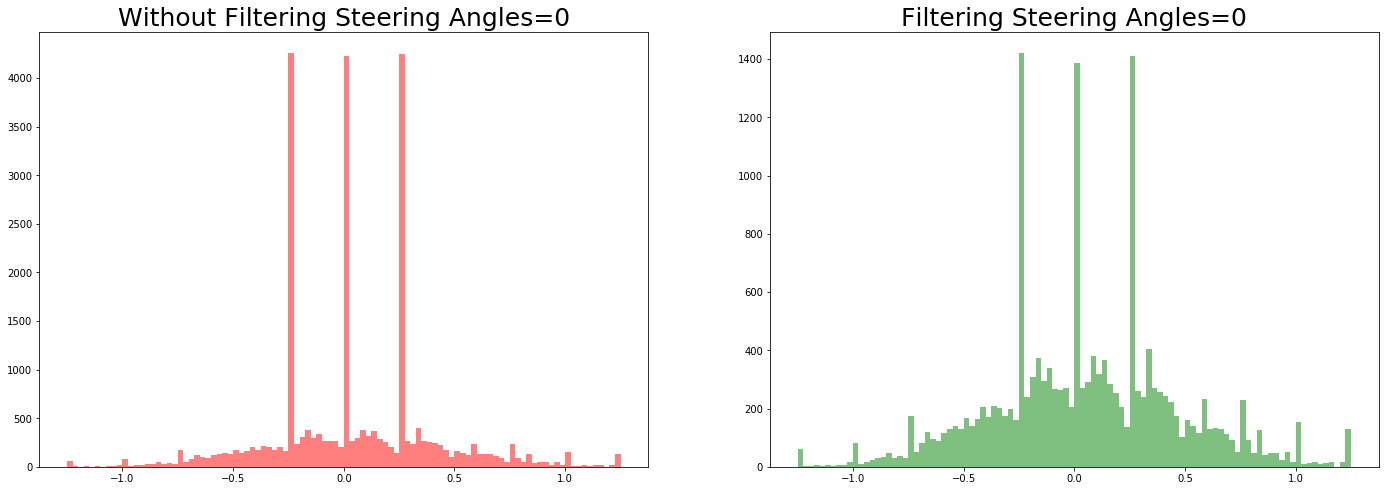

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
'''
plt.hist(steering_angles2, bins=100)
#plt.hist(steering_angles,bins=100)
'''
list1 = np.random.rand(10)*2.1
list2 = np.random.rand(10)*3.
bins = np.linspace(0, 1, 3)

fig, ax = plt.subplots(1,2, figsize=(24, 8))
ax[0].hist(steering_angles2, bins=100, alpha = 0.5, color = 'r')
ax[0].set_title("Without Filtering Steering Angles=0", fontsize=25)
ax[1].hist(steering_angles,bins=100, alpha = 0.5, color = 'g')
ax[1].set_title("Filtering Steering Angles=0", fontsize=25)

plt.savefig('./examples/Steering-angle-filters.png')
plt.show()



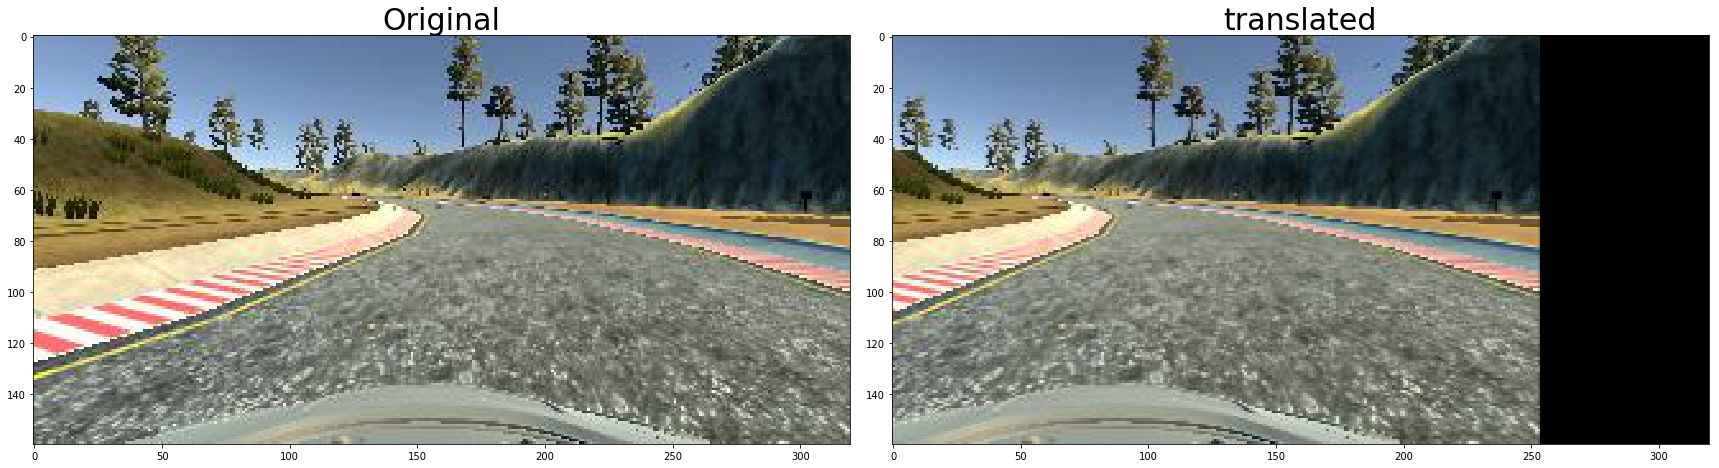

In [19]:
def trans_image(image,steer):
    '''
    We decide to use shearing in the preprocessing
    '''
    # https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
    # https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713
    trans_range = 150

    translate_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + translate_x/trans_range*2*.2
    tr_y = 0
    
    rows,cols,channels = image.shape
    
    Trans_M = np.float32([[1,0,translate_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang
img = cv2.cvtColor(cv2.imread(images[0]) , cv2.COLOR_BGR2RGB)
image_translated,steer = trans_image(img, steering_angles[0])
display_two(img, image_translated,"Original","translated")